### Preprosessing Class

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import datetime as dt
from sklearn.preprocessing import StandardScaler

class Preproses:
    
    def __init__(self,endo,exo,start,end,out=1,lag=20,batch=1):
        
        self.endo= endo    # variabel endogenous, dalam bentuk list
        self.exo= exo      # variabel exogenous, dalam bentuk list
        self.start= start  # start date
        self.end= end      # end date
        self.out=out       # length of output series, timestep
        self.lag=lag       # length of feature sebagai input masing-masing variable
        self.batch=batch   # batch size need when it train
        self.df = self.download()  #sekali download simpan variable
        
   
    def download(self):
        
        ticks= self.endo+ self.exo
        
        ticker= yf.Tickers(ticks)
        
        download=ticker.download(start=self.start,end=self.end)['Close']
        download.fillna(method='backfill',inplace=True)     #Isi nan value
        download=download[download>0]                       #filter negatif value
        download.dropna(inplace=True)                       # drop Nan value
        
        return download
    
    
    def df_excel(self,path):                               #overwriting data external
        
        excel=pd.read_excel(path,index_col=0)              #columns bentuk data list
        
        self.df=self.df.merge(excel,'inner',left_index=True, right_index=True)
        
    
    @staticmethod
    def scaling(series):                              # Fungsi scaler
        
        scl=StandardScaler()
        model=scl.fit(series)
        trans=scl.fit_transform(series)
        
        return model,trans
    
   
    def loop_trans (self):                             # scale every variabel 
        
        tran_set={}
        for col in self.df.columns:
            
            df_x=np.array(self.df[col]).reshape(-1,1) #input scaling adalah numpy array 2D
            df_xtrans=self.scaling(df_x)              # fungsi scaling
            xtrans=df_xtrans[1]                       # ambil hasil transform berupa numpy 2D
            tran_set[col]=xtrans                      # pass to dictionary
            
        return tran_set
    
    
    def loop_mod (self,var):                           # acces model scale every variabel f/ invers
        
        mod_set={}
        for col in self.df.columns:
            
            df_x=np.array(self.df[col]).reshape(-1,1)  #input scaling adalah numpy array 2D
            df_mod=self.scaling(df_x)                  # fungsi scaling
            x_mod=df_mod[0]                            # ambil hasil transform berupa numpy 2D
            mod_set[col]=x_mod                         # pass to dictionary
            
        return mod_set[var]
    
    @staticmethod
    def split_data(data,lag,out,batch):                        #untuk split data dari data yang ada
                                                               #data numpy 2D
        
        rest_data=len(data[0])                                 #data yang di pass kan adalah data numpy 2D, 1 row
        minimum_data=lag+out                                   #data yang diperlukan untuk satu batch perhitungan
        
        splited_data=data[:,:lag]                              #first splitted data
        n=1                                                    #first N looping
        rest_data-=1                                             #data sudah jadi satu perlu dikurangi satu         
        
        while rest_data>=minimum_data:
            
            if ((n+1)%batch)!=0:
                next_splited_data=data[:,n:n+lag]
                splited_data=np.concatenate((splited_data,next_splited_data),axis=0)
                
                rest_data-=1
                n+=1
            
            elif ((n+1)%batch)==0 and (n+1)==batch :         
                next_splited_data=data[:,n:n+lag]
                splited_data=np.concatenate((splited_data,next_splited_data),axis=0)
                
              
                out_data=data[:,n+lag:n+lag+out]          #first batch out_data
                
                rest_data-=1
                n+=1
                
            else :
                next_splited_data=data[:,n:n+lag]
                splited_data=np.concatenate((splited_data,next_splited_data),axis=0)
                next_out_data=data[:,n+lag:n+lag+out] 
                

                out_data=np.concatenate((out_data,next_out_data),axis=0)
                
                rest_data-=1
                n+=1
                
        return splited_data,out_data
    
    
    @staticmethod
    def split_dat(data,lag,out):                    #untuk split data dari data yang ada jika jumlah batch 1
    
        rest_data=len(data[0])                      #data yang di pass kan adalah data numpy 2D, 1 row
        minimum_data=lag+out                        #data yang diperlukan untuk satu batch perhitungan
        
        splited_data=data[:,:lag]                   #first splitted data
        out_data=data[:,lag:lag+out]
        n=1                                         #first N looping
    
        while rest_data>minimum_data:
            
            next_splited_data=data[:,n:n+lag]
            next_out_data=data[:,n+lag:n+lag+out]
            splited_data=np.concatenate((splited_data,next_splited_data),axis=0)
            out_data=np.concatenate((out_data,next_out_data),axis=0)
            
            rest_data-=1
            n+=1
            
        return splited_data, out_data
    
    def get_data(self):                     # ambil data untuk bisa dilakukan split, hasil scalling
    
        data_set=self.loop_trans()          # ambil data dalam bentuk numpy yang belum tersplit
        
        cols=data_set.keys()                # untuk itterable, loop_trans bentuk dictionary
        
        if self.batch==1:
            
            set_asplit={}
            for col in cols:
                dat_col=data_set[col].reshape(1,-1)
                split=self.split_dat(dat_col,self.lag,self.out)
                
                set_asplit[col]=split[0]
                
        else:
            
            set_asplit={}
            for col in cols:
                dat_col=data_set[col].reshape(1,-1)
                split=self.split_data(dat_col,self.lag,self.out,self.batch)
                
                set_asplit[col]=split[0]
                
        return set_asplit
    
    def concate(self):                  #concate beberapa ticker untuk create feature
    
        data_concate=self.get_data()[self.endo[0]]
        
        cols=self.df.columns[1:]
        
        for tick in cols:
            
            next_data_concate=self.get_data()[tick]
            
            data_concate=np.concatenate((data_concate,next_data_concate),axis=1)
            
        return data_concate
                    
    @property 
    def label(self):
        data_set=self.loop_trans()
        data=data_set[endo[0]].reshape(1,-1)                   #get data endo
        
        
        if self.batch==1:
            lab=self.split_dat(data,self.lag,self.out)[1]       #get data out
            
        else:
            lab=self.split_data(data,self.lag,self.out,self.batch)[1]      #get daya out
            
        return lab
    
    
    @staticmethod
    def reduce(data,len_need_data):    #fungsi panjang feature yang digunakan untuk 
                                       #--> menyesuaikan jumlah batch
     
        return data[:len_need_data,:]
        
    @property 
    def feature(self):
        
        len_label=len(self.label)
        
        len_need_data=len_label*self.batch
        
        data=self.concate()
        
        data_reduce=self.reduce(data,len_need_data)
        
        
        feat=data_reduce.reshape(len_label,self.batch,-1)
        
        return feat
    

class Prediction(Preproses):
    
    def __init__(self,endo,exo,start,end,start_pred,out=1,lag=20,batch=1):
        
        super().__init__(endo,exo,start,end,out,lag,batch)
        self.start_pred= start_pred
        self.df_pred=self.download_pred()
        
    @property
    def size_data (self):
        
        timestemp= self.feature.shape[1]
        lag=self.lag
        total=timestemp+lag
        
        return lag,timestemp,total                  # data test predict lag x timestemp
    
    def download_pred(self):
        
        need_dl= self.size_data[2]
        
        end_download= self.start_pred-dt.timedelta(days=1)  
        
        start_download=end_download-dt.timedelta(days=need_dl+100)  #safety 100 jika ada data yang nan
        
        tick= self.endo+ self.exo
        
        ticker= yf.Tickers(tick)
        
        download=ticker.download(start=start_download,end=end_download)['Close']
        download.fillna(method='backfill',inplace=True)      #Isi nan value
        download=download[download>0]                        #filter negatif value
        download.dropna(inplace=True)                        # drop Nan value
        
        return download
    
    def df_excel_pred(self,path):                       #overwriting
        
        excel=pd.read_excel(path,index_col=0)              #columns bentuk data list
        
        self.df_pred=self.df_pred.merge(excel,'inner',left_index=True, right_index=True)
    
    @staticmethod 
    def scaling_pred(data,model):            #data bentu dataframe
                                                 # col pada data frame (ticker)
                                                 # model scalar per ticker
        
            X_pred=np.array(data)
            X_pred=X_pred.reshape(-1,1)         #data belum ditransform dalam bentuk numpy 2D
            
            X_scl= model.transform(X_pred)      # take transform per ticker
            
            return X_scl                        # bentuk numpy 2D dengan satu column
    
    @staticmethod
    def reduce_pred(data,len_data):            #data hasil scaling pred numpy
                                                # len data : panjang total data yang diperlukan : size_data
    
        X_reduce=data.flatten()
        
        X_reduce=X_reduce[-len_data:]
        
        return X_reduce
        
    
    @staticmethod 
    def split_pred(data,lag,timestep):           #data hasil reduce pred berupa numpy 1D flatten
                                                #lag panjang lag : self.lag
                                                #timestep jumlah batch
            splited_row=data[:lag].reshape(1,-1)   #perlu dijadikan 2D untuk proses concatenate
            n=1
            
            while n<timestep:
                next_row=data[n:n+lag].reshape(1,-1)
                splited_row=np.concatenate((splited_row,next_row),axis=0)
                n+=1
                
            return splited_row
                
        
    def data_srs(self):
        
        data=self.df_pred 
        
        cols= data.columns
        
        data_scal_red_split={}
        
        for col in cols :
            
            data_col=data[col]
            model=self.loop_mod(col)
            
            data_scal=self.scaling_pred(data_col,model)
            
            data_red=self.reduce_pred(data_scal,self.size_data[2])
            
            data_split=self.split_pred(data_red, self.lag, self.batch)
            
            data_scal_red_split[col]=data_split
            
        return data_scal_red_split
    
    def concate_pred(self):
        
        data=self.data_srs()
        endo=self.endo[0]
        exo=self.df_pred.columns[1:]
        
        data_concate=data[endo]    #first numpy from endo 
        
        for key in exo:
            
            next_dat_concate=data[key]
            
            data_concate=np.concatenate((data_concate,next_dat_concate),axis=1)
            
        return data_concate
            
            
    @property
    def feature_pred(self):
        
        data=self.concate_pred()
        timestemp=data.shape[0]
        unit=data.shape[1]
        
        return data.reshape(1,timestemp,unit)             #butuh reshape 2D jadi 3D dan transpose kolom to baris
    
    
    def hasil_pred(self,output_model):
        
        scl_hasil=self.loop_mod(self.endo[0])
        
        return scl_hasil.inverse_transform(output_model)
    
    @property
    def index_pred(self):
        
        index=[self.start_pred]
        
        i=1
        
        while len(index)<self.out:
        
            next_day=self.start_pred+dt.timedelta(days=i)
            
            if next_day.weekday() >4:
                pass
            else:
                index.append(next_day)
                
            i=i+1
                
        return index
    
    def dframe_hasil(self,output_model):
        
        indek=self.index_pred
        df_hasil= self.hasil_pred(output_model).reshape(-1)
        
        return pd.DataFrame(df_hasil,index=indek,columns=["Prediction"])

C:\Users\anggoro.budiono\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Input Data  

In [2]:
start_date=dt.date(2020,3,1)
end_date=dt.date(2022,9,30)
start_pred=dt.date(2022,10,1)

endo=["ADRO.JK"]
exo=['^JKSE']

### Make Feature and Label Data 

In [3]:
trial=Prediction(endo=endo, exo=exo, start=start_date, end=end_date, start_pred=start_pred)

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


In [14]:
trial.df_excel(r'C:\Users\anggoro.budiono\Documents\Python Ang\00.TEMPLATE\technical_adro.xlsx')

In [15]:
x=trial.feature
y=trial.label

x=x[:600,:,:]   #supaya dapat di batching pada saat proses training
y=y[:600,:]     #supaya dapat di batching pada saat proses training

### Deep Learning Model

#### Split Data Training

In [7]:
from sklearn.model_selection import train_test_split as split

In [16]:
x_train,x_val,y_train,y_val=split(x,y,test_size=0.25,random_state=24)

In [17]:
x_train.shape,x_val.shape

((450, 1, 220), (150, 1, 220))

In [29]:
inp_shape=x_train.shape[1],x_train.shape[2]

In [31]:
output=y_train.shape[1]

#### Model

In [32]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [33]:
model=Sequential()
model.add(LSTM(units=200,input_shape=inp_shape,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(output))

In [34]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 1, 200)            336800    
                                                                 
 dropout_15 (Dropout)        (None, 1, 200)            0         
                                                                 
 lstm_16 (LSTM)              (None, 1, 100)            120400    
                                                                 
 dropout_16 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_17 (LSTM)              (None, 1, 100)            80400     
                                                                 
 dropout_17 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_18 (LSTM)              (None, 1, 50)            

In [35]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt,loss='mean_squared_error')

history=model.fit(x_train,y_train,batch_size=32,epochs=500,validation_data=(x_val,y_val),verbose=1)

Epoch 1/500
15/15 [==============================] - 12s 162ms/step - loss: 0.9219 - val_loss: 0.9839
Epoch 2/500
15/15 [==============================] - 0s 15ms/step - loss: 0.9193 - val_loss: 0.9802
Epoch 3/500
15/15 [==============================] - 0s 15ms/step - loss: 0.9148 - val_loss: 0.9728
Epoch 4/500
15/15 [==============================] - 0s 14ms/step - loss: 0.9057 - val_loss: 0.9579
Epoch 5/500
15/15 [==============================] - 0s 15ms/step - loss: 0.8866 - val_loss: 0.9267
Epoch 6/500
15/15 [==============================] - 0s 14ms/step - loss: 0.8507 - val_loss: 0.8665
Epoch 7/500
15/15 [==============================] - 0s 15ms/step - loss: 0.7847 - val_loss: 0.7606
Epoch 8/500
15/15 [==============================] - 0s 16ms/step - loss: 0.6764 - val_loss: 0.6084
Epoch 9/500
15/15 [==============================] - 0s 16ms/step - loss: 0.5288 - val_loss: 0.4365
Epoch 10/500
15/15 [==============================] - 0s 16ms/step - loss: 0.3817 - val_loss: 0.28

15/15 [==============================] - 0s 16ms/step - loss: 0.0156 - val_loss: 0.0094
Epoch 163/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0173 - val_loss: 0.0075
Epoch 164/500
15/15 [==============================] - 0s 14ms/step - loss: 0.0188 - val_loss: 0.0085
Epoch 165/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0169 - val_loss: 0.0083
Epoch 166/500
15/15 [==============================] - 0s 14ms/step - loss: 0.0156 - val_loss: 0.0104
Epoch 167/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0171 - val_loss: 0.0082
Epoch 168/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0154 - val_loss: 0.0079
Epoch 169/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0158 - val_loss: 0.0084
Epoch 170/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0170 - val_loss: 0.0078
Epoch 171/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0157 - val_loss: 0

15/15 [==============================] - 0s 17ms/step - loss: 0.0133 - val_loss: 0.0085
Epoch 323/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0130 - val_loss: 0.0071
Epoch 324/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0127 - val_loss: 0.0069
Epoch 325/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0150 - val_loss: 0.0062
Epoch 326/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0146 - val_loss: 0.0084
Epoch 327/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0116 - val_loss: 0.0062
Epoch 328/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0161 - val_loss: 0.0077
Epoch 329/500
15/15 [==============================] - 0s 16ms/step - loss: 0.0139 - val_loss: 0.0078
Epoch 330/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0131 - val_loss: 0.0067
Epoch 331/500
15/15 [==============================] - 0s 17ms/step - loss: 0.0136 - val_loss: 0

15/15 [==============================] - 0s 14ms/step - loss: 0.0124 - val_loss: 0.0072
Epoch 483/500
15/15 [==============================] - 0s 14ms/step - loss: 0.0114 - val_loss: 0.0068
Epoch 484/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0129 - val_loss: 0.0062
Epoch 485/500
15/15 [==============================] - 0s 14ms/step - loss: 0.0129 - val_loss: 0.0072
Epoch 486/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0112 - val_loss: 0.0082
Epoch 487/500
15/15 [==============================] - 0s 14ms/step - loss: 0.0111 - val_loss: 0.0067
Epoch 488/500
15/15 [==============================] - 0s 14ms/step - loss: 0.0129 - val_loss: 0.0060
Epoch 489/500
15/15 [==============================] - 0s 14ms/step - loss: 0.0105 - val_loss: 0.0073
Epoch 490/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0103 - val_loss: 0.0072
Epoch 491/500
15/15 [==============================] - 0s 15ms/step - loss: 0.0126 - val_loss: 0

#### Plot Over & Under Fitting

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

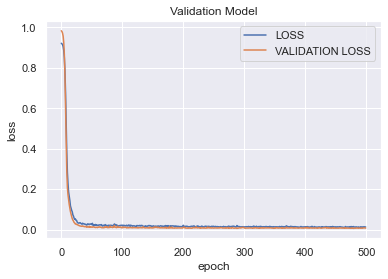

In [38]:
sns.set_theme()
plt.plot(history.history['loss'],label='LOSS')
plt.plot(history.history['val_loss'],label='VALIDATION LOSS')
plt.title('Validation Model')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

#### Plot Data Fitting 

In [39]:
# Looping prediksi dari Model
y_list_pred=[]                              
dim_1,dim_2=x.shape[1],x.shape[2]

for i in x :
    a=i.reshape(-1,dim_1,dim_2)
    y_pred=model.predict(a)
    y_hasil= trial.hasil_pred(y_pred)[0][0]
    y_list_pred.append(y_hasil)

In [40]:
# concate hasil prediksi dan real

df_adro=trial.df['ADRO.JK']
df_index_adro=df_adro[20:][:600]
df_index_adro=pd.DataFrame(df_index_adro)
df_index_adro['Prediksi']=y_list_pred

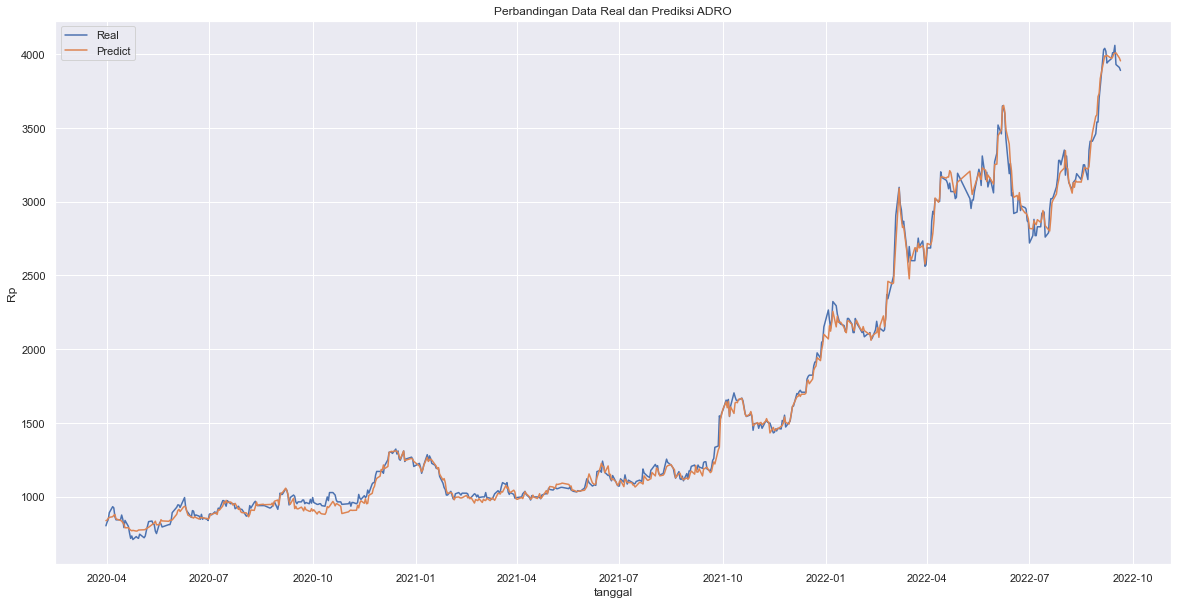

In [43]:
sns.set_theme()
plt.figure(figsize=(20,10))
plt.plot(df_index_adro['ADRO.JK'],label="Real")
plt.plot(df_index_adro['Prediksi'],label="Predict")
plt.title('Perbandingan Data Real dan Prediksi ADRO')
plt.xlabel('tanggal')
plt.ylabel('Rp')
plt.legend()
plt.show()